# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

In [2]:
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [3]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from fastprogress import progress_bar

from utilities.utils import load_json, load_pickle
from utilities.pathManager import fetchPaths
from utilities.MonitorUnifiedBDD import MonitorBDD

# Seed

In [6]:
np.random.seed(SEED)

# Import Data

In [45]:
DATASETS = ['MNIST', 'FashionMNIST', 'GTSRB']
model_stats = {}

for DATASET in DATASETS:
    # fetch paths
    paths = fetchPaths(base, DATASET, '', False)
    path_data = paths['data']
    path_model_stats = paths['saved_models'].parent.parent

    # import Data
    model_stats[DATASET] = pd.read_csv(path_model_stats / f"{DATASET}_model_stats.csv")
    model_stats[DATASET]['dataset'] = DATASET
    
    # convert to percentage
    for c in ['train_loss', 'test_loss','train_acc', 'test_acc']:
        model_stats[DATASET][c] = round(model_stats[DATASET][c] * 100, 1)
    
    # convert string list to python list
    for i in range(model_stats[DATASET].shape[0]):
        model_stats[DATASET].at[i, 'train_losses'] = ast.literal_eval(model_stats[DATASET].loc[i, 'train_losses'])
        model_stats[DATASET].at[i, 'test_losses'] = ast.literal_eval(model_stats[DATASET].loc[i, 'test_losses'])
        model_stats[DATASET].at[i, 'train_accs'] = ast.literal_eval(model_stats[DATASET].loc[i, 'train_accs'])
        model_stats[DATASET].at[i, 'test_accs'] = ast.literal_eval(model_stats[DATASET].loc[i, 'test_accs'])

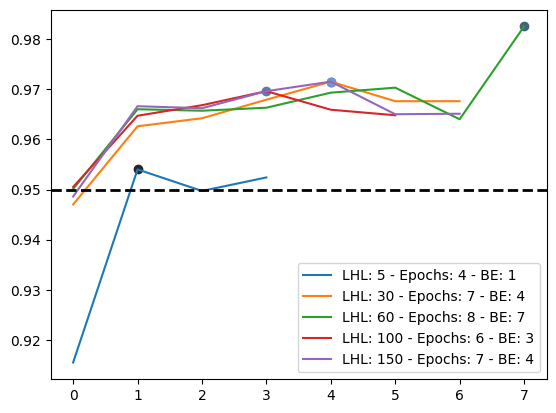

In [14]:
DATASET = 'MNIST'
df_stat = model_stats[DATASET]
col = 'test_accs'
palette = sns.dark_palette('#69d', df_stat.shape[0])


for i in range(df_stat.shape[0]):
    plt.scatter(df_stat['best_epoch'][i], df_stat['test_acc'][i], color=palette[i])
    sns.lineplot(
        x=range(len(df_stat[col][i])),
        y=df_stat[col][i],
        palette=[palette[i]],
        label=f"LHL: {df_stat['lhl'][i]} - Epochs: {df_stat['epochs'][i]} - BE: {df_stat['best_epoch'][i]}"
    )
    
plt.axhline(0.95, color='black', linewidth=2, linestyle='--')
plt.show()

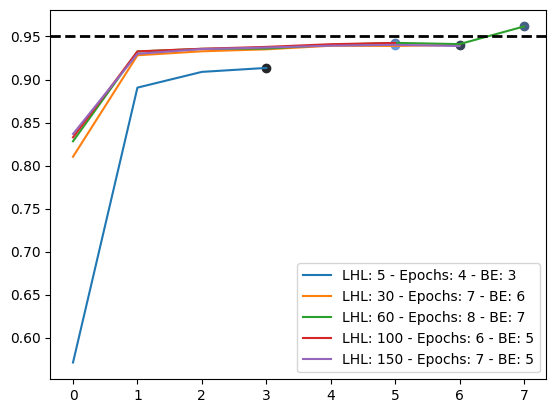

In [16]:
col = 'train_accs'

for i in range(df_stat.shape[0]):
    idx = np.argmax(df_stat[col][i])
    plt.scatter(idx, df_stat[col][i][idx], color=palette[i])
    sns.lineplot(
        x=range(len(df_stat[col][i])),
        y=df_stat[col][i],
        palette=[palette[i]],
        label=f"LHL: {df_stat['lhl'][i]} - Epochs: {df_stat['epochs'][i]} - BE: {idx}"
    )
    
plt.axhline(0.95, color='black', linewidth=2, linestyle='--')
plt.show()

<Axes: xlabel='lhl'>

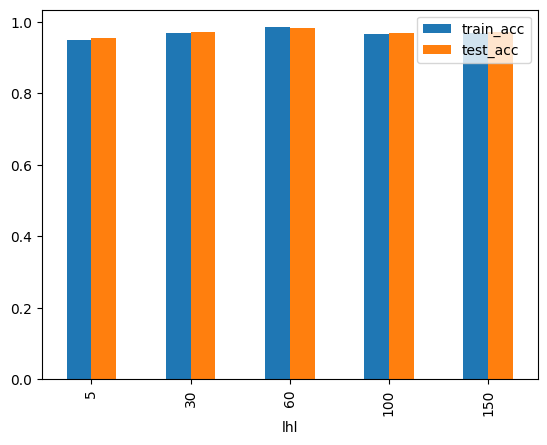

In [17]:
df_stat[['lhl','train_acc','test_acc']].set_index('lhl').plot.bar()

<Axes: xlabel='lhl'>

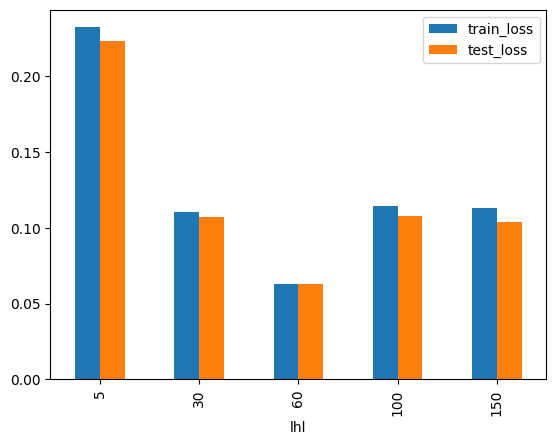

In [18]:
df_stat[['lhl','train_loss', 'test_loss']].set_index('lhl').plot.bar()

In [26]:
sel_cols = ['dataset','lhl', 'optim', 'scheduler', 'epochs', 'train_loss', 'test_loss','train_acc', 'test_acc']
df_model_results = pd.concat([df_t[sel_cols] for k, df_t in model_stats.items()])

In [31]:
from IPython.display import display
import ipywidgets as widgets

In [68]:
@widgets.interact(dataset=DATASETS)
def ttt(dataset='MNIST'):
    print()
    df = df_model_results.loc[df_model_results['dataset'] == dataset].copy()
    print(f"{df['dataset'][0]} - Optimizer: {df['optim'][0]}, Scheduler: {df['scheduler'][0]}")
    df.drop(['dataset', 'optim', 'scheduler'], axis=1, inplace=True)
    
    for _, r in df.iterrows():
        print('\t'.join(map(lambda x: f'{x}%',r)))

interactive(children=(Dropdown(description='dataset', options=('MNIST', 'FashionMNIST', 'GTSRB'), value='MNIST…